**Setup Your Environment**
<blockquote> a.) Install CDS Application Programming Interface (API)</blockquote>

In [88]:
!pip3 -q install cdsapi

In [89]:
# Other requirements
!pip3 -q install cfgrib ecmwflibs
!pip3 -q install xarray netcdf4
!pip3 -q install matplotlib
!pip3 install cartopy

<blockquote>b.) Import Libraries</blockquote>

In [105]:
import os

# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualizng data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()
# Disable xarray runtime warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)


**Search and download the river discharge data**  
  <blockquote>Enter your CDS API Key</blockquote>

In [109]:
if os.path.isfile("~/.cdsapirc"):
  cdapi_kwargs = {}
else:
  URL = 'https://cds.climate.copernicus.eu/api/v2'
  KEY = '#########################################'  # Replace with your own API key
  cdsapi_kwargs = {'url': URL, 'key': KEY}

DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

<blockquote>Find and Download data</blockquote>

In [110]:
download_file = f"{DATADIR}/glofas-2014_2024.grib"
if not os.path.isfile(download_file):
    c = cdsapi.Client(
        **cdsapi_kwargs
    )
    c.retrieve(
        'cems-glofas-historical',
        {
            'system_version': 'version_4_0',
            'hydrological_model': 'lisflood',
            'product_type': 'consolidated',
            'variable': 'river_discharge_in_the_last_24_hours',
            'hyear': [f"{year}" for year in range(2014, 2025)],
            'hmonth': 'april',
            'hday': [f"{day:02d}" for day in range(1,31)],
            'format': 'grib',
            'area': [-0.5, 28, -13, 42,],
        },
    ).download(download_file)

2024-08-22 13:47:18,181 INFO Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
INFO:cdsapi:Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
2024-08-22 13:47:18,185 WARNING MOVE TO

**Explore and view the data**

In [111]:
glofas_data = xr.open_dataset(download_file)
glofas_data

<xarray.Dataset> Size: 94MB
Dimensions:     (time: 330, latitude: 252, longitude: 282)
Coordinates:
  * time        (time) datetime64[ns] 3kB 2014-04-01 2014-04-02 ... 2024-04-30
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 2kB -0.475 -0.525 -0.575 ... -12.98 -13.03
  * longitude   (longitude) float64 2kB 27.98 28.03 28.08 ... 41.92 41.97 42.02
    valid_time  (time) datetime64[ns] 3kB ...
Data variables:
    dis24       (time, latitude, longitude) float32 94MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-22T13:52 GRIB to CDM+CF via cfgrib-0.9.1...

<blockquote>Getting an overview of the study area</blockquote>

In [112]:
# Create a simple plotting function that we can use throughout this notebook
def plot_map(
    plot_data,
    title='',
    cbar_label='',
    cmap='PuBu',
    extent=[28, 42, -13, -0.5],
    **pcolorkwargs
):
    # Populate the title and cbar_label with attributes from the plot_data if they have not been
    #  explicitly specified
    title = title or plot_data.attrs.get('long_name', title)
    cbar_label = cbar_label or plot_data.attrs.get('units', cbar_label)

    # Create a figure with a cartopy projection assigned which allows plotting geospatial data
    fig, ax = plt.subplots(
        1, 1, figsize = (18, 9), subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Plot the data on our figure
    im = ax.pcolormesh(
        plot_data.longitude, plot_data.latitude, plot_data, cmap=cmap, **pcolorkwargs
    )

    # Add some additional features
    ax.set_title(title, fontsize=16)
    ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.coastlines(color='black')

    # Add country borders in red
    ax.add_feature(cfeature.BORDERS, edgecolor='black', lw=1.5, ls=":")

    # Set the plot domain/extent
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add a colour bar
    cbar = plt.colorbar(im,fraction=0.04, pad=0.01)
    cbar.set_label(cbar_label, fontsize=12)

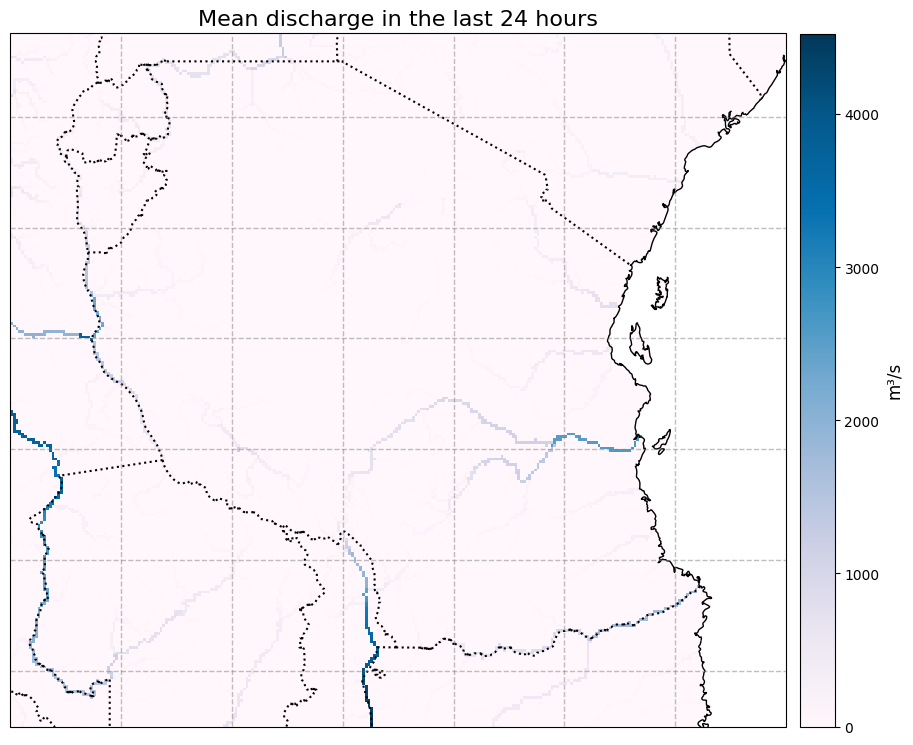

In [113]:
mean_data = glofas_data.dis24.mean(dim='time')
mean_data = mean_data.assign_attrs(**glofas_data.dis24.attrs)
plot_map(
    mean_data,
    cbar_label="m³/s"
  )

<blockquote>Accessing the upstream area data</blockquote>

In [114]:
# choose a target location to download the file:
upstream_area_fname = f"uparea_glofas_v4_0.nc"
upstream_area_file = os.path.join(DATADIR, upstream_area_fname)
# If we have not already downloaded the file, we download it
if not os.path.isfile(upstream_area_file):
  u_version=2 # file version
  upstream_data_url = (
      f"https://confluence.ecmwf.int/download/attachments/242067380/{upstream_area_file}?"
      f"version={u_version}&modificationDate=166860469007&api=v2&download=true"
  )
  import requests
  result = requests.get(upstream_data_url)
  with open(upstream_area_file, 'wb') as f:
    f.write(result.content)
# Open file and print contents
upstream_area = xr.open_dataset(upstream_area_file)
upstream_area

<xarray.Dataset> Size: 86MB
Dimensions:    (longitude: 7200, latitude: 3000)
Coordinates:
  * longitude  (longitude) float64 58kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * latitude   (latitude) float64 24kB 89.97 89.92 89.88 ... -59.92 -59.97
Data variables:
    uparea     (latitude, longitude) float32 86MB ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    Conventions:                CF-1.9
    GDAL_PCRASTER_VALUESCALE:   VS_SCALAR
    GDAL_AREA_OR_POINT:         Area
    GDAL:                       GDAL 3.2.1, released 2020/12/29
    NCO:                        netCDF Operators version 4.9.7 (Homepage = ht...
    history_of_appended_files:  Fri Dec 10 11:49:42 2021: Appended file ldd_O...
    history:                    Mon Nov 14 17:49:16 2022: cdo chname,lon,long...
    CDO:                        Climate Data Operators version 1.9.10 (https:...

<blockquote>Reduce the upstream area to the domain of the data</blockquote>

In [115]:
# Reduce the upstream area data to the domain of the river discharge

# Get the latitude and longitude limits of the data
lat_limits = [glofas_data.latitude.values[i] for i in [0, -1]]
lon_limits = [glofas_data.longitude.values[i] for i in [0, -1]]
up_lats = upstream_area.latitude.values.tolist()
up_lons = upstream_area.longitude.values.tolist()

lat_slice_index = [
    round((i - up_lats[0])/(up_lats[1] - up_lats[0]))
    for i in lat_limits
]
lon_slice_index = [
    round((i - up_lons[0])/(up_lons[1] - up_lons[0]))
    for i in lon_limits
]

# Slice upstream area to Tanzania region:
red_upstream_area = upstream_area.isel(
    latitude=slice(lat_slice_index[0], lat_slice_index[1]+1),
    longitude=slice(lon_slice_index[0], lon_slice_index[1]+1)
)

# There are very minor rounding differences, so we update the lat/lons from the glofas_data
red_upstream_area = red_upstream_area.assign_coords({
    'latitude': glofas_data.latitude,
    'longitude': glofas_data.longitude
})

# Add the upstream area to the main data object and print the updated glofas data object
glofas_data['uparea'] = red_upstream_area['uparea']
glofas_data

<xarray.Dataset> Size: 94MB
Dimensions:     (time: 330, latitude: 252, longitude: 282)
Coordinates:
  * time        (time) datetime64[ns] 3kB 2014-04-01 2014-04-02 ... 2024-04-30
    step        timedelta64[ns] 8B 1 days
    surface     float64 8B 0.0
  * latitude    (latitude) float64 2kB -0.475 -0.525 -0.575 ... -12.98 -13.03
  * longitude   (longitude) float64 2kB 27.98 28.03 28.08 ... 41.92 41.97 42.02
    valid_time  (time) datetime64[ns] 3kB ...
Data variables:
    dis24       (time, latitude, longitude) float32 94MB 8.281 0.5625 ... nan
    uparea      (latitude, longitude) float32 284kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-22T13:52 GRIB to CDM+CF via cfgrib-0.9.1...

<blockquote>Mask the river discharge data</blockquote>

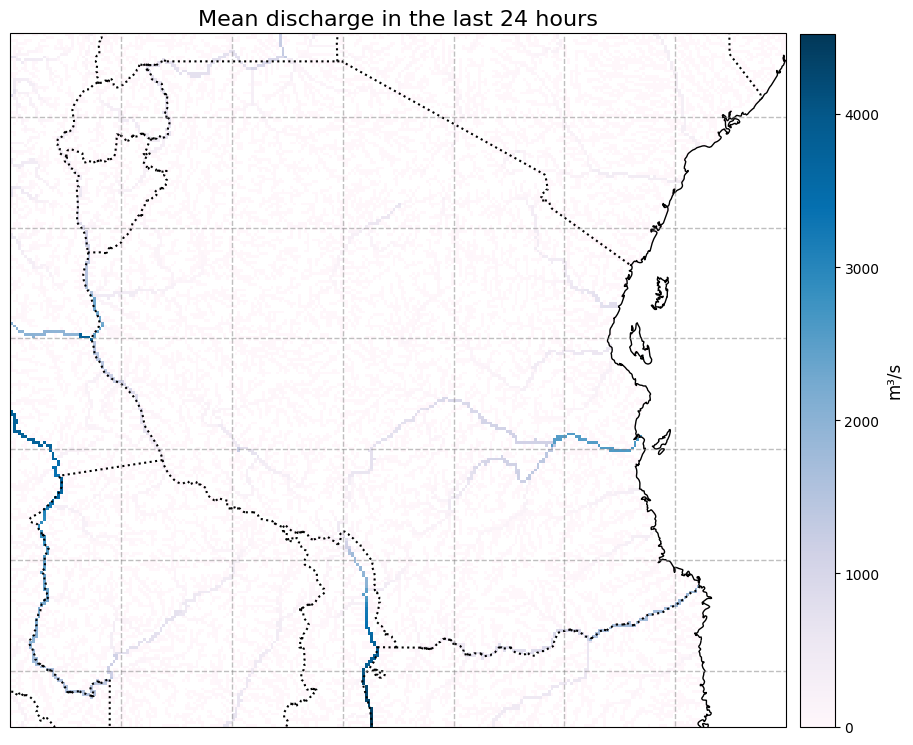

In [116]:
glofas_data_masked = glofas_data.where(glofas_data.uparea >= 100.e6)
mean_masked_data = glofas_data_masked.dis24.mean(dim='time').assign_attrs(glofas_data_masked.dis24.attrs)
plot_map(
    mean_masked_data,
    cbar_label="m³/s"
)

**Compare the April 2024 river discharge to the previous 10 years**

<blockquote>- The choice of a historical period of 10 years (here) is just for demonstrative purposes, a thorough analysis would use a longer reference period</blockquote>

In [122]:
# select the 2014-2023 data
glofas_historical_period = glofas_data_masked.sel(time=slice("2014", "2023"))

glofas_dis24_domain_mean = glofas_historical_period.dis24.mean(["longitude", "latitude"])
# calculate the mean discharge over the whole domain, for each day in April
glofas_xy_climatology = glofas_dis24_domain_mean.groupby('time.day').mean("time")

# calculate the maximum and the minimum discharge  over the whole domain, for each day in April
glofas_xy_clim_min = glofas_dis24_domain_mean.groupby('time.day').min('time')
glofas_xy_clim_max = glofas_dis24_domain_mean.groupby('time.day').max('time')
# Calculate the 10th and 90th percentiles of discharge rate of the whxole domain
glofas_xy_clim_quantiles = glofas_dis24_domain_mean.groupby('time.day').quantile(dim='time', q=[0.1,0.9])

# calculate the mean discharge over the whole domain for each day in April 2024
glofas_xy_2024 = glofas_data_masked.dis24.sel(time="2024")
glofas_xy_2024_mean = glofas_xy_2024.mean(['longitude', 'latitude']).groupby('time.day').mean("time")

Text(0, 0.5, 'Daily river discharge ($m^{3}s^{-1}$)')

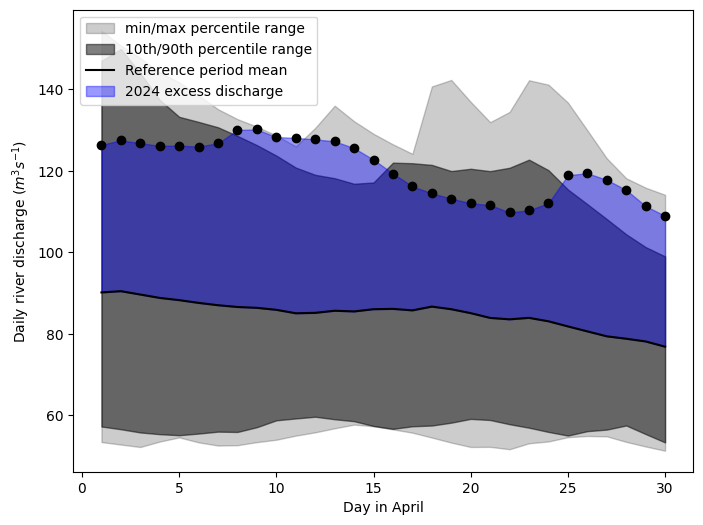

In [124]:
# Create a figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

# Plot the minimum to maximum range
ax.fill_between(
    np.arange(1, 31), glofas_xy_clim_min.values, glofas_xy_clim_max.values,
    color="k", alpha=0.2, label='min/max percentile range'
)

# Plot the 10th to 90th percentile range
ax.fill_between(
    np.arange(1, 31),
    glofas_xy_clim_quantiles.isel(quantile=0).values,
    glofas_xy_clim_quantiles.isel(quantile=1).values,
    color="k", alpha=0.5, label='10th/90th percentile range'
)

# Plot the mean for the 10 year period
(line_base,) = plt.plot(
    np.arange(1, 31), glofas_xy_climatology.values, color="k", label="Reference period mean"
)

# Plot the region where 2024 is greater than the mean in blue
ax.fill_between(
    range(1, int(glofas_xy_2024_mean.shape[0]) + 1),
    glofas_xy_climatology.values[: int(glofas_xy_2024_mean.shape[0])],
    glofas_xy_2024_mean.values,
    color="b",
    alpha=0.4,
    where=glofas_xy_2024_mean.values >= glofas_xy_climatology.values[: int(glofas_xy_2024_mean.shape[0])],
    interpolate=True, label="2024 excess discharge"
)

# Plot the region where 2024 is less than the mean in red
ax.fill_between(
    range(1, int(glofas_xy_2024_mean.shape[0]) + 1),
    glofas_xy_climatology.values[: int(glofas_xy_2024_mean.shape[0])],
    glofas_xy_2024_mean.values,
    color="r",
    alpha=0.4,
    where=glofas_xy_2024_mean.values < glofas_xy_climatology.values[: int(glofas_xy_2024_mean.shape[0])],
    interpolate=True,
)

# Plot the 2024 data points
dots = ax.scatter(
    range(1, int(glofas_xy_2024_mean.shape[0]) + 1),
    glofas_xy_2024_mean.values,
    color="k",
    # label="2024",
    zorder=2,
)

# Add a legend and axis labels
ax.legend(loc='upper left')
plt.xlabel("Day in April")
plt.ylabel("Daily river discharge ($m^{3}s^{-1}$)")

In [125]:
# Calculate the climatology for the historical period: 2014-2023
glofas_historical_period = glofas_data_masked.sel(time=slice("2014","2023"))

# glofas_climatology = glofas_data_masked.groupby('time.dayofyear').mean("time")
glofas_climat_quantiles = glofas_historical_period.groupby('time.dayofyear').quantile(dim='time', q=[0.1,0.9])

# Calculate the anomaly w.r.t the above climatology
# glofas_anomaly = glofas_data_masked.groupby('time.dayofyear) - glofas_climatology
# Calculate this a relative anomaly
# glofas_relanom = glofas_anomaly.groupby('time.dayofyear')/glofas_anomaly

glofas_high = glofas_data_masked.groupby('time.dayofyear') > glofas_climat_quantiles.sel(quantile=0.9)
glofas_high = glofas_high.where(glofas_data.uparea > 100e6)

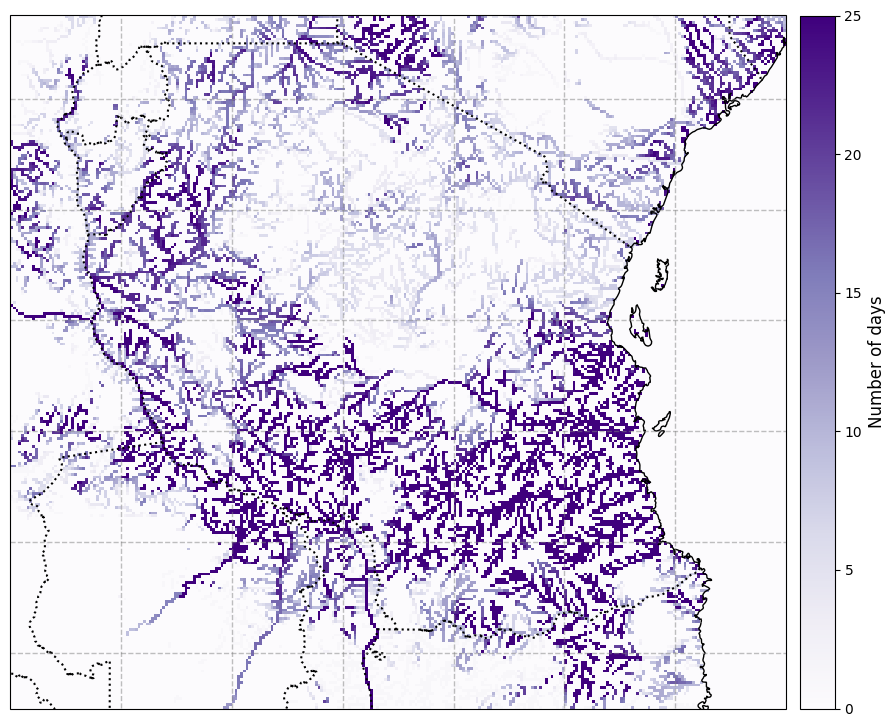

In [126]:
# Plot the data
year='2024'
number_of_high_days = glofas_high.sel(time=year).dis24.sum(dim='time')
number_of_high_days = number_of_high_days.assign_attrs(glofas_high.dis24.attrs)
plot_map(
    number_of_high_days, vmax=25, cmap='Purples', cbar_label='Number of days'
)